In [1]:
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install scikit-learn

### Загружаем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Библиотека для разбиения датасета на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
#Библиотека для подбора лучших параметров модели
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

#Библиотека для обучния модели с несколькими выходами
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error, r2_score


### Загружаем датасет и исследуем его

In [3]:
# Загружаю датасет, записываю его в переменные X и y. 
dataset = pd.read_csv('ebw_data.csv')
dataset.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [4]:
#Размер датасета
dataset.shape

(72, 6)

In [5]:
#Проверяю, есть ли пустые значения
dataset.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

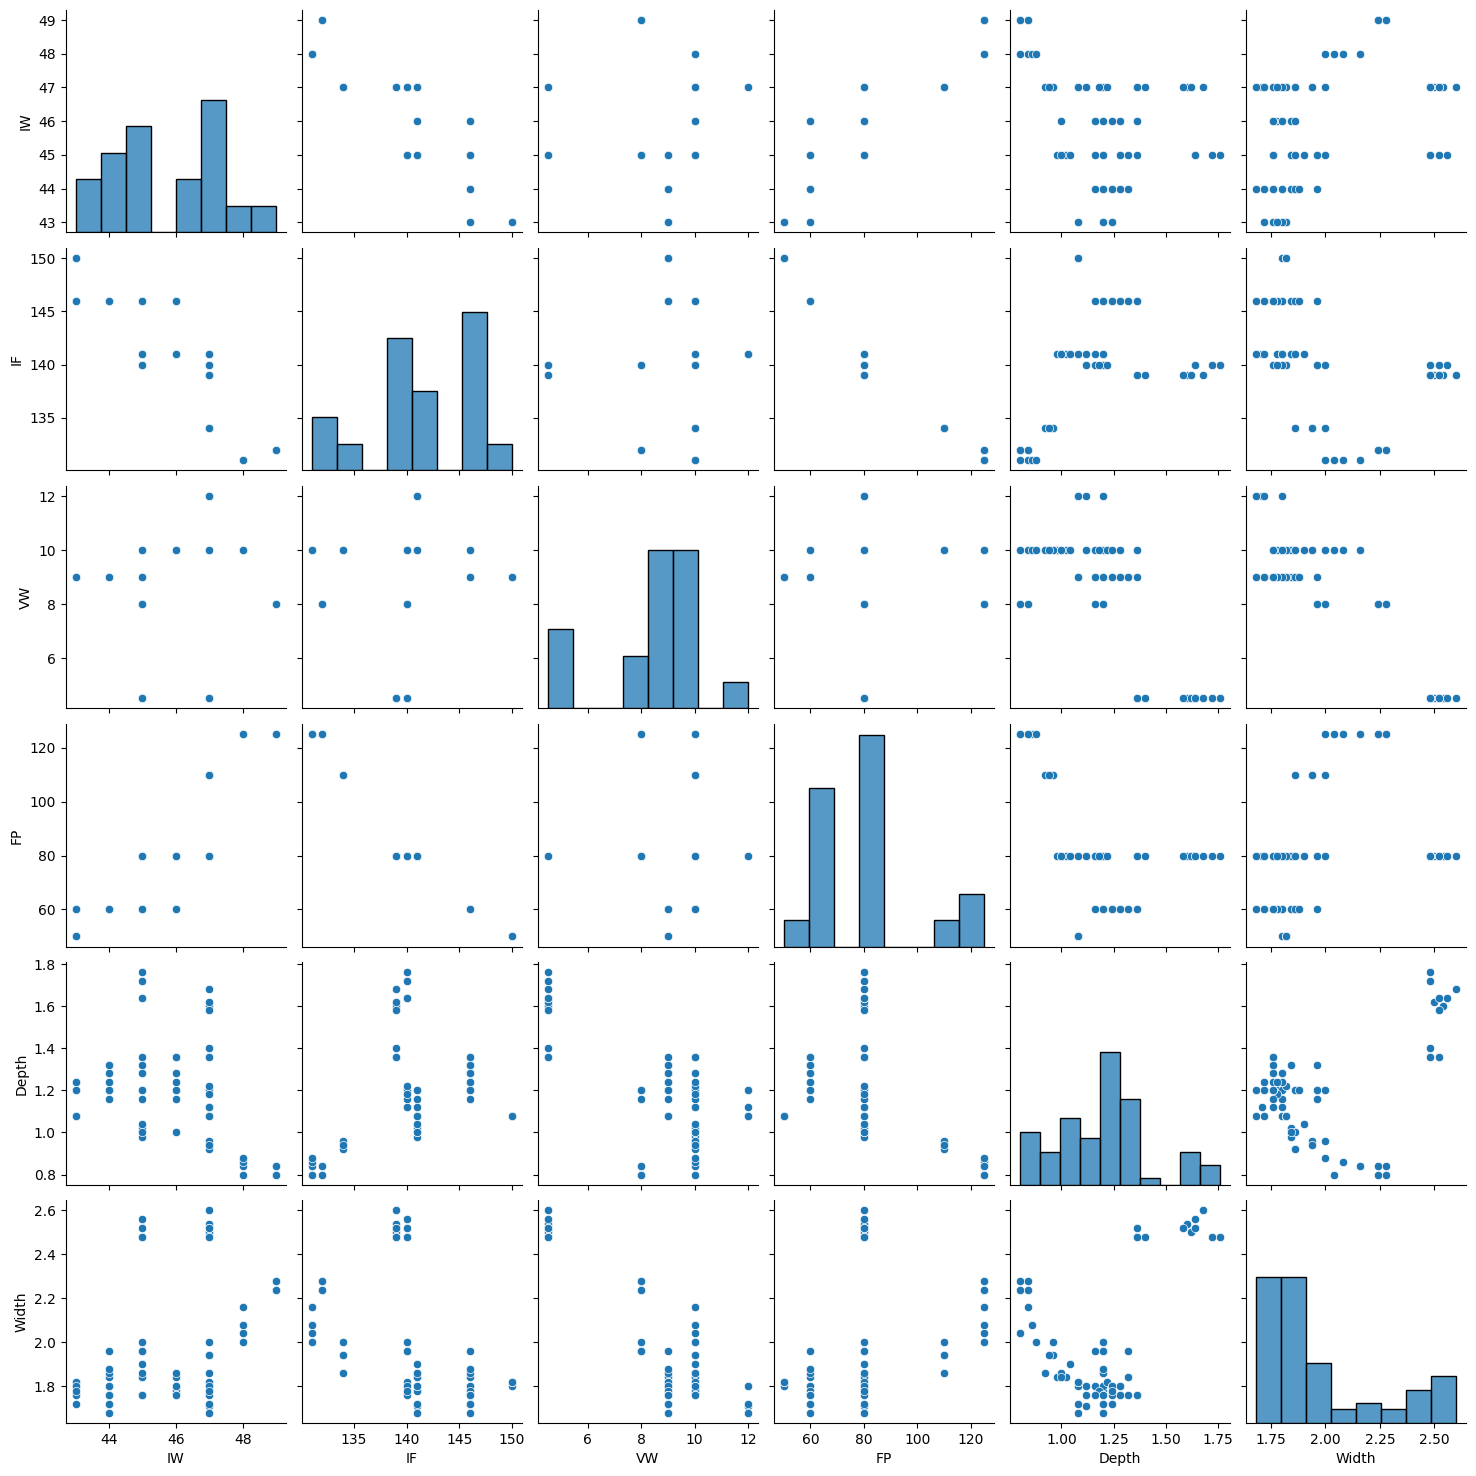

In [6]:
#Строю графики для оценки данных датасета
sns.pairplot(dataset) 

In [7]:
#По графикам видно, что столбцы IF и IW, IF и FP коррелируют между собой. Матрица корреляции это подтверждает
dataset.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


<AxesSubplot: >

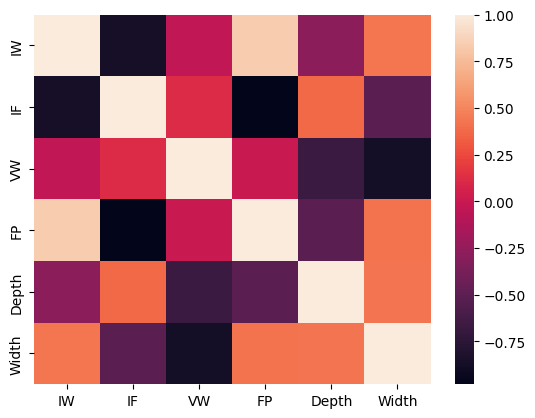

In [8]:
#Более наглядно на тепловой карте корреляции датасета
sns.heatmap(dataset.corr())

### Подготовка данных для обучения

In [9]:
#Разделяю датасет на параметры и предсказываемые значение (таргеты)
X = dataset.drop(['Depth','Width'], axis=1).values
y = dataset[['Depth','Width']].values
dataset_names = ['IW',	'IF',	'VW',	'FP']

In [10]:
#Разбиваю датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Выбор наилучшей модели для обучения

In [11]:
#создаю список для перебора вариантов моделей
regressors = [
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    Ridge()
]

In [12]:
#Перебираем в цикле модели и выбираем лучшую модель
head = 5 
for model in regressors[:head]:
    multiout = MultiOutputRegressor(model).fit(X_train, y_train)
    y_pred = multiout.predict(X_test)
    print(model)
    print("\tMean squared error:", MultiOutputRegressor(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", MultiOutputRegressor(r2_score(y_test, y_pred)))
    print()

GradientBoostingRegressor()
	Mean squared error: MultiOutputRegressor(estimator=0.004390517561711526)
	R2 score: MultiOutputRegressor(estimator=0.928772826714408)

RandomForestRegressor()
	Mean squared error: MultiOutputRegressor(estimator=0.004825985280600209)
	R2 score: MultiOutputRegressor(estimator=0.9212196159056285)

DecisionTreeRegressor()
	Mean squared error: MultiOutputRegressor(estimator=0.004414911616161616)
	R2 score: MultiOutputRegressor(estimator=0.9284402744346074)

Ridge()
	Mean squared error: MultiOutputRegressor(estimator=0.010511668848125464)
	R2 score: MultiOutputRegressor(estimator=0.8270030065271472)



### Выбираю для дальнейшего обучения GradientBoostingRegressor

In [13]:
#Выбираю для дальнейшего исследования GradientBoostingRegressor
#Так как показатели этой модели наилучшие при параметрах по-умолчанию
#Пробую подобрать параметры, при которых модель будет работать еще лучше
#Создаю словарь с параметрами для поиска лучшего решения
parameters = { 'n_estimators' :[70, 100, 120],
              'max_depth':[2,3,5], # установка глубины дерева 
              'max_features':[2,3,4], # количество признаков для построение разветвлений
              'min_samples_leaf': [1,2,3], #минимальное число объектов в листе
              'min_samples_split':[2,3,5,7,10] #минимальное число объектов, при котором происходит разветвление
             }

In [14]:
#Обучаем модель отдельно для Depth и Width. 
grid = GradientBoostingRegressor(criterion = "squared_error")
gridCV = GridSearchCV(grid,
                      parameters,
                     )
model_Depth = gridCV.fit(X, y[:,0]) #Отдельно обучение для Depth
params_Depth = model_Depth.best_params_ #Лучшие параметры для Depth
print('Лучшие параметры для Depth', params_Depth,'\n')
model_Width = gridCV.fit(X, y[:,1])  #Отдельно обучение для Width
params_Width = model_Width.best_params_ #Лучшие параметры для Width
print('Лучшие параметры для Width', params_Width,'\n')

Лучшие параметры для Depth {'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70} 

Лучшие параметры для Width {'max_depth': 2, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 70} 



In [15]:
#Подставляю подобранные параметры в модель для Depth  
GBR_Depth  = GradientBoostingRegressor(**params_Depth).fit(X_train, y_train[:,0])
y_pred_best_Depth = GBR_Depth.predict(X_test)

In [16]:
#Подставляю подобранные параметры в модель для Width
GBR_Width  = GradientBoostingRegressor(**params_Width).fit(X_train, y_train[:,1])
y_pred_best_Width = GBR_Width.predict(X_test)

### Оценка качества модели

In [17]:
#Среднеквадратичная ошибка и коэффициент детерминации для Depth
mse_Depth = mean_squared_error(y_test[:,0], y_pred_best_Depth)
print("MSE_Depth on test set: {:.4f}".format(mse_Depth))
R2_Depth = r2_score(y_test[:,0], y_pred_best_Depth)
print("R2_Depth on test set: {:.4f}".format(R2_Depth))

#Среднеквадратичная ошибка и коэффициент детерминации для Width
mse_Width = mean_squared_error(y_test[:,1], y_pred_best_Width)
print("MSE_Width on test set: {:.4f}".format(mse_Width))
R2_Width = r2_score(y_test[:,1], y_pred_best_Width)
print("R2_Width on test set: {:.4f}".format(R2_Width))

MSE_Depth on test set: 0.0072
R2_Depth on test set: 0.8732
MSE_Width on test set: 0.0023
R2_Width on test set: 0.9731


C:\Users\NANCHPOU SKT Znanie\.conda\envs\ML_Project\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


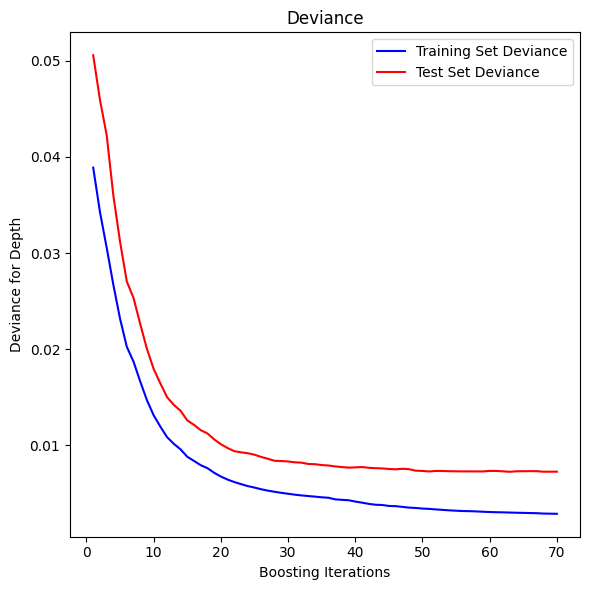

In [18]:
#Построю графики обучения на параметрах для Depth
test_score = np.zeros((params_Depth["n_estimators"],), dtype=np.float64)
for i, y_pred_best_Depth in enumerate(GBR_Depth.staged_predict(X_test)):
    test_score[i] = GBR_Depth.loss_(y_test[:,0], y_pred_best_Depth)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params_Depth["n_estimators"]) + 1,
    GBR_Depth.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params_Depth["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance for Depth")
fig.tight_layout()
plt.show()

C:\Users\NANCHPOU SKT Znanie\.conda\envs\ML_Project\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


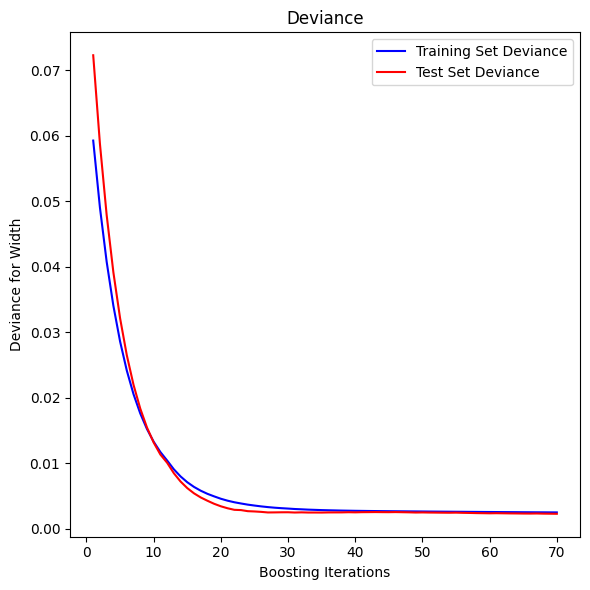

In [19]:
#Построю графики обучения на параметрах для Width
test_score = np.zeros((params_Width["n_estimators"],), dtype=np.float64)
for i, y_pred_best_Width in enumerate(GBR_Width.staged_predict(X_test)):
    test_score[i] = GBR_Width.loss_(y_test[:,1], y_pred_best_Width)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params_Width["n_estimators"]) + 1,
    GBR_Width.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params_Width["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance for Width")
fig.tight_layout()
plt.show()